In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') 
yearly_seasonality=True

In [2]:
import pandas as pd
train = pd.read_csv("C:/Users/yugan/Documents/Artificial Intelligence/train.csv")

In [3]:
train['application_date']=train['application_date'].astype('datetime64')

In [4]:
train1=train[train['segment']==1].groupby(['application_date'])['case_count'].sum().reset_index()

In [5]:
train2=train[train['segment']==2].groupby(['application_date'])['case_count'].sum().reset_index()

892.633939339763


C:\Users\yugan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


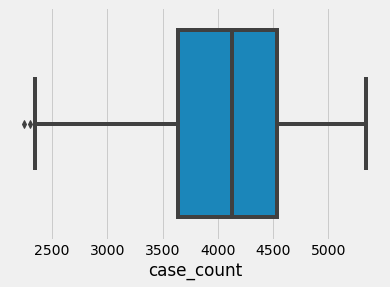

In [6]:
import seaborn as sns
sns.boxplot('case_count',data=train1)
Q1 = train1['case_count'].quantile(0.25)
Q3 = train1['case_count'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [7]:
train1 = train1[~((train1['case_count'] < (Q1 - 1.5 * IQR)) |(train1['case_count'] > (Q3 + 1.5 * IQR)))]

In [8]:
train1

,application_date,case_count
0,2019-07-06,2996.203594
2,2019-07-08,3794.600600
3,2019-07-09,3467.728304
4,2019-07-10,3803.340273
5,2019-07-11,3737.827113
...,...,...
82,2019-09-26,4923.476931
83,2019-09-27,4992.651487
84,2019-09-28,4543.352040
85,2019-09-29,3794.632690


# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

In [9]:
def create_features(df, label=None):
    """
    Creates time series features from application_datetime index.
    """
    df = df.copy()
  
    df['dayofweek'] = df['application_date'].dt.dayofweek
    df['quarter'] = df['application_date'].dt.quarter
    df['month'] = df['application_date'].dt.month
    df['year'] = df['application_date'].dt.year
    df['dayofyear'] = df['application_date'].dt.dayofyear
    df['dayofmonth'] = df['application_date'].dt.day
    df['weekofyear'] = df['application_date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(train1, label='case_count')

features_and_target = pd.concat([X, y], axis=1)

<ipython-input-9-d982aeac0829>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['application_date'].dt.weekofyear


In [10]:
X, y = create_features(train2, label='case_count')
features_and_target1 = pd.concat([X, y], axis=1)

<ipython-input-9-d982aeac0829>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['application_date'].dt.weekofyear


In [11]:
features_and_target['ds']=train1['application_date'].astype('datetime64')

In [12]:
features_and_target1['ds']=train2['application_date'].astype('datetime64')

In [13]:
# See our features and target

features_and_target=features_and_target.rename({'case_count':'y'},axis=1)
features_and_target1=features_and_target1.rename({'case_count':'y'},axis=1)

## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

# Train/Test Split
Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [25]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y,ds
0,5,3,7,2019,187,6,27,2996.203594,2019-07-06
2,0,3,7,2019,189,8,28,3794.600600,2019-07-08
3,1,3,7,2019,190,9,28,3467.728304,2019-07-09
4,2,3,7,2019,191,10,28,3803.340273,2019-07-10
5,3,3,7,2019,192,11,28,3737.827113,2019-07-11


In [15]:

pjme_train = features_and_target[:600].copy()
pjme_test = features_and_target[600:].copy()
pjme_train1 = features_and_target1[:600].copy()
pjme_test1 = features_and_target1[600:].copy()

# Simple Prophet Model
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.

In [16]:
features_and_target.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear', 'y', 'ds'],
      dtype='object')

In [26]:
exogenous_features=['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear']

In [31]:
model=Prophet()
for feature in exogenous_features:
     model.add_regressor(feature)

In [ ]:
model.fit(pjme_train[["ds", "y"] + exogenous_features])


In [35]:
model1 = Prophet()
for feature in exogenous_features:
     model1.add_regressor(feature)
model1.fit(pjme_train1[["ds", "y"] + exogenous_features])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# Predict on training set with model
pjme_test_fcst = model.predict(pjme_test)

ValueError: Dataframe has no rows.

In [ ]:
pjme_test_fcst1=model1.predict(pjme_test1)

In [ ]:
pjme_test_fcst.head()

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

In [ ]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

# Look at first month of predictions

# Error Metrics

Our RMSE error is 43761675  
Our MAE error is 5181.78  
Our MAPE error is 16.5%

by comparison in the XGBoost model our errors were significantly less (8.9% MAPE):
[Check that out here](https://www.kaggle.com/robikscube/hourly-time-series-forecasting-with-xgboost/)

In [ ]:
mean_squared_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
mean_absolute_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test1['y'],
                   y_pred=pjme_test_fcst1['yhat'])

# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

In [36]:
!pip install holidays

In [37]:
import holidays
holidays=pd.DataFrame({'ds':list(holidays.IND(years=[2017,2018,2019,2020]).keys()),'holiday':list(holidays.IND(years=[2017,2018,2019,2020]).values())})

In [38]:

model_with_holidays = Prophet(holidays=holidays)
for feature in exogenous_features:
    model_with_holidays.add_regressor(feature)
model_with_holidays.fit(pjme_train[["ds", "y"] + exogenous_features])
# Setup and train model with holidaysmodel = Prophet()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Predict With Holidays

In [39]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(pjme_test)

ValueError: Dataframe has no rows.

## Plot Holiday Effect

In [ ]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
Suprisingly the error has gotten worse after adding holidays.

In [ ]:
mean_squared_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

In [ ]:
mean_absolute_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['y'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

In [ ]:
pjme_test_fcst_with_hols[pjme_test_fcst_with_hols['yhat']<0]

In [ ]:
test = pd.read_csv("../input/test-data/test.csv")
test1=test[test['segment']==1].copy()
test2=test[test['segment']==2].copy()
test1['application_date']=test1['application_date'].astype('datetime64')
test2['application_date']=test2['application_date'].astype('datetime64')

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from application_datetime index.
    """
    df = df.copy()
  
    df['dayofweek'] = df['application_date'].dt.dayofweek
    df['quarter'] = df['application_date'].dt.quarter
    df['month'] = df['application_date'].dt.month
    df['year'] = df['application_date'].dt.year
    df['dayofyear'] = df['application_date'].dt.dayofyear
    df['dayofmonth'] = df['application_date'].dt.day
    df['weekofyear'] = df['application_date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X= create_features(test1)



In [ ]:
test1

In [ ]:
X1= create_features(test2)

In [ ]:
X1

In [ ]:
test2

In [ ]:
X['ds']=test1['application_date'].astype('datetime64')
X1['ds']=test2['application_date'].astype('datetime64')

In [ ]:
predict=model.predict(X)

In [ ]:
predict1=model.predict(X1)

In [ ]:
predict[predict['yhat']<0]

In [ ]:
predict1[predict1['yhat']<0]

In [ ]:
final=pd.concat([predict,predict1])

In [ ]:
final

In [ ]:
test

In [ ]:
final=final.reset_index()

In [ ]:
test['case_count']=final['yhat']



In [ ]:
test.to_csv('submission.csv',index=False)